Notebook with methods to plot the embeddings (umap) and do some clustering.

In [301]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import auc, roc_curve, roc_auc_score

from contrastive.evaluation.train_multiple_classifiers import compute_auc
from contrastive.utils.models_database import load_model_embs, load_model_preds

In [274]:
# test model
test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#1"
parent_dir_betavae = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10/09-21-24_0"
parent_dir_simclr = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10"
dataset='cingulate_ACCpatterns_1'

# Functions

In [275]:
def get_model_path(parent_dir):
    path = os.path.abspath(parent_dir)
    return [entry.path for entry in os.scandir(path) if entry.is_dir()]

In [262]:
def get_classifier_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[~aucs.index.isin(['label', 'median_pred', 'mean_pred'])]
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [263]:
def plot_svm_predictions(prediction_df, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75],
                         cmap = ['b', 'r'], verbose=False):
    # plot for predicted labels
    n_i = len(quantiles)
    n_j = len(thresholds)
    plt.figure(figsize=(n_i*6.4, n_j*4.8))
    
    for i,quantile in enumerate(quantiles):
        svm_model, model_auc = get_classifier_by_quality(prediction_df, q=quantile)
        model_auc = "{:.2f}".format(model_auc)
        if verbose:
            print(f"Chosen svm model for quantile {quantile} (ie auc={model_auc}):")
        
        for j,threshold in enumerate(thresholds):            
            mid_svm_pred = (prediction_df[svm_model] >= threshold).astype(int)
            if verbose:
                print(mid_svm_pred[:5])
                print("shape:", mid_svm_pred.shape)

            colors = [cmap[i] for i in mid_svm_pred]
            """if show_wrong_class:
                colors = []
                for i in range(prediction_df.shape[0]):
                    if prediction_df[la]"""
            # compute accuracy
            accuracy = ((prediction_df[svm_model] >= threshold) == prediction_df.label).astype(float).mean()

In [264]:
def full_histogram(model_path, dataset='cingulate_ACCpatterns_1', quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75], verbose=True):
    
    ## plot the svm curves
    plt.figure(figsize=(10, 7.5))
    fig = plt.imshow(mpimg.imread(model_path+f"/{dataset}_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    # give the model auc?


    ## compute the clusters on the embeddings
    # load the data
    data_df = load_model_embs(model_path, dataset=dataset)
    if verbose:
        print("Data df:")
        print(data_df[:5])

    # load the predictions
    prediction_df = load_model_preds(model_path, dataset=dataset)
    if verbose:
        print("Prediction df:")
        print(prediction_df[:5])

    # plot the svm predictions
    plot_svm_predictions(prediction_df, quantiles=quantiles, thresholds=thresholds,
                         verbose=verbose)

    ## generate the result df
    res_df = pd.DataFrame(index=data_df.index)
    res_df['true_labels'] = prediction_df.label

    return res_df

In [276]:
def get_different_model_preds(parent_dir=None):
    model_paths = get_model_path(parent_dir=parent_dir)
    print(model_paths)
    fusion = load_model_preds(model_paths[0], dataset=dataset)[["label"]]
    # print(fusion.head())
    i=0
    for model_path in model_paths:
        prediction_df = load_model_preds(model_path, dataset=dataset)[["average_model"]]
        prediction_df.rename(columns={'average_model': f"average_model{i}"}, inplace=True)
        fusion = pd.merge(fusion, prediction_df, left_index=True, right_index=True)
        # print(fusion.head())
        i+=1
    return fusion

## Gets histograms and correlations

In [277]:
fusion_simclr = get_different_model_preds(parent_dir_simclr)

['/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10/09-21-24_2', '/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10/09-21-24_3', '/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10/09-21-24_1', '/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10/09-21-24_4', '/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10/09-21-24_0']


In [278]:
fusion_betavae = get_different_model_preds(parent_dir_betavae)

['/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#1', '/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#5', '/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#3', '/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2', '/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#4']


In [279]:
fusion = fusion_simclr

In [280]:
a = fusion.iloc[:,1:].values

(array([12., 21., 29., 63., 77., 59., 46., 31., 18.,  9.]),
 array([0.07231207, 0.15983663, 0.2473612 , 0.33488577, 0.42241034,
        0.50993491, 0.59745947, 0.68498404, 0.77250861, 0.86003318,
        0.94755775]),
 <BarContainer object of 10 artists>)

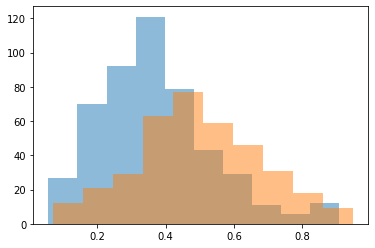

In [281]:
plt.hist(fusion[fusion.label==0].iloc[:,1:].values.reshape(-1,1), alpha=0.5)
plt.hist(fusion[fusion.label==1].iloc[:,1:].values.reshape(-1,1), alpha=0.5)

(array([ 2.,  3.,  4., 13., 12., 19.,  8.,  6.,  3.,  3.]),
 array([0.08535203, 0.16664923, 0.24794643, 0.32924364, 0.41054084,
        0.49183804, 0.57313524, 0.65443244, 0.73572964, 0.81702684,
        0.89832405]),
 <BarContainer object of 10 artists>)

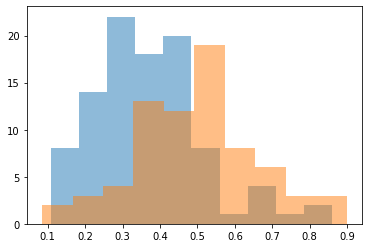

In [282]:
plt.hist(fusion[fusion.label==0].iloc[:,1:].mean(axis=1),alpha=0.5)
plt.hist(fusion[fusion.label==1].iloc[:,1:].mean(axis=1), alpha=0.5)

In [283]:
curves = roc_curve(fusion.label, fusion.iloc[:,1:].mean(axis=1))
roc_auc = roc_auc_score(fusion.label, fusion.iloc[:,1:].mean(axis=1))

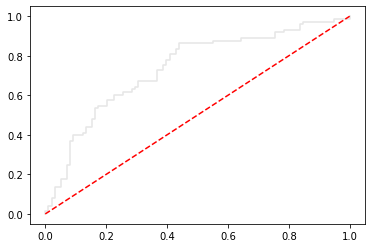

In [284]:
plt.plot(curves[0], curves[1], color='black', alpha=0.1)
plt.plot([0,1],[0,1],color='r', linestyle='dashed')

In [285]:
roc_auc

0.737489516354487

In [286]:
(fusion.iloc[:,1:].mean(axis=1)>0.5).sum()/171

0.2982456140350877

(array([60., 27., 19., 10., 55.]),
 array([0, 1, 2, 3, 4, 5]),
 <BarContainer object of 5 artists>)

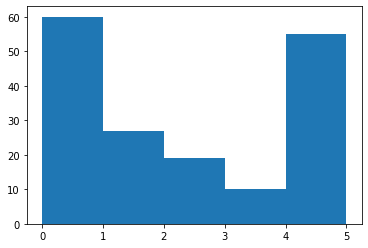

In [287]:
b = (a>=0.45).astype(float)
plt.hist((b.sum(axis=1)), bins=[0,1,2,3,4,5])

In [288]:
(b.sum(axis=1)>2).sum()*100./171.

38.01169590643275

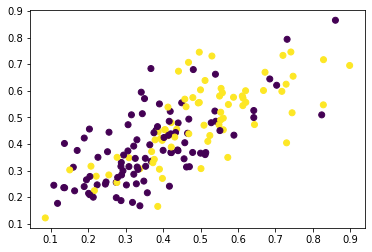

In [299]:
plt.scatter(fusion_simclr.iloc[:,1:].mean(axis=1), fusion_betavae.iloc[:,1:].mean(axis=1), c=fusion.label)

<AxesSubplot:xlabel='label', ylabel='average_model0'>

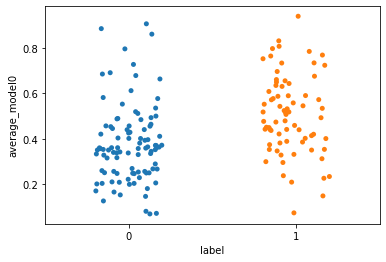

In [305]:
# plt.scatter(fusion_simclr.iloc[:,1], fusion_simclr.label)
sns.stripplot(data=fusion_simclr, x=fusion_simclr.label, y="average_model0", jitter=.2)
        

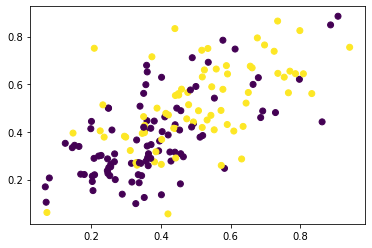

In [298]:
plt.scatter(fusion_simclr.iloc[:,1], fusion_betavae.iloc[:,4], c=fusion.label)

## Data histogram

In [138]:
data_df = load_model_embs(test_model, dataset=dataset)
data_df.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10
ID,,,,,,,,,,
1-20FORHU_t0,1.979331,0.188219,-0.860599,1.882955,-1.815237,0.490921,-0.610081,0.316156,-0.385939,-0.725653
1-23CREES_t0,1.693041,0.156626,2.026151,0.534890,0.971220,0.811980,-1.612516,1.410623,-0.368849,0.469374
2-02FERMA_t0,0.406861,-1.133447,-0.584822,1.731163,-1.789493,2.171829,0.562189,-1.219443,0.713960,-1.233641
2-04HEBTO_t0,-0.448091,-0.140248,1.673997,0.763530,-0.609522,0.426811,-0.532921,-0.605824,1.452826,-0.696157
2-08BESAG_t0,0.830921,-1.647052,-0.290958,0.575538,-0.445105,1.428980,-1.848081,0.703917,-0.474971,-1.134753


In [139]:
prediction_df = load_model_preds(test_model, dataset=dataset)
prediction_df.head()

,label,predicted_0,predicted_1,predicted_2,predicted_3,predicted_4,predicted_5,predicted_6,predicted_7,predicted_8,...,predicted_242,predicted_243,predicted_244,predicted_245,predicted_246,predicted_247,predicted_248,predicted_249,median_pred,mean_pred
Subject,,,,,,,,,,,,,,,,,,,,,
1-20FORHU_t0,0,0.526348,0.541101,0.515345,0.500000,0.524626,0.542548,0.526741,0.518914,0.527116,...,0.516510,0.523135,0.528352,0.527248,0.536658,0.521674,0.507269,0.512076,0.523893,0.523926
1-23CREES_t0,0,0.846085,0.881579,0.794757,0.797713,0.798921,0.852369,0.849957,0.816173,0.856873,...,0.828941,0.820665,0.840655,0.822077,0.849160,0.838557,0.786077,0.780368,0.830779,0.827395
2-02FERMA_t0,0,0.256575,0.234561,0.292298,0.274325,0.301814,0.271490,0.252930,0.276987,0.245862,...,0.261141,0.278431,0.265044,0.282775,0.267059,0.258286,0.288658,0.300690,0.270119,0.271505
2-04HEBTO_t0,1,0.739267,0.776277,0.694005,0.692451,0.700431,0.749844,0.742765,0.711954,0.749012,...,0.721539,0.716990,0.735254,0.719510,0.745206,0.731305,0.684568,0.682028,0.726057,0.723480
2-08BESAG_t0,0,0.357312,0.346996,0.377387,0.361619,0.387037,0.373310,0.354935,0.368519,0.350156,...,0.356985,0.371001,0.363819,0.375392,0.368159,0.356847,0.372076,0.381689,0.366323,0.366457


In [140]:
prediction_df.label.mean()

0.4269005847953216

0.4359620505428157
0.31743711129676044


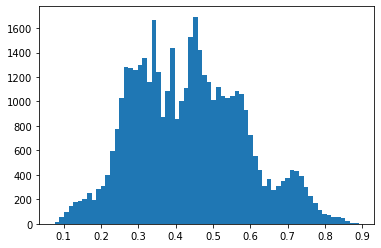

In [141]:
print(prediction_df.iloc[:,1:].values.mean())
print((prediction_df.iloc[:,1:].values >0.5).mean())
pred_a = prediction_df.iloc[:,1:].values
_ = plt.hist(pred_a.reshape(-1,1), bins='auto') 
plt.show()

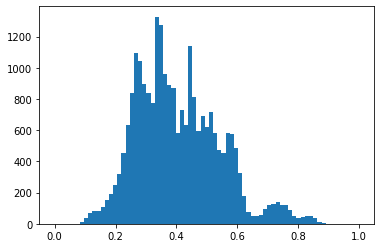

In [142]:
pred_a_0 = prediction_df[prediction_df.label==0].iloc[:,1:].values
_ = plt.hist(pred_a_0.reshape(-1,1), bins='auto', range=(0,1)) 
plt.show()

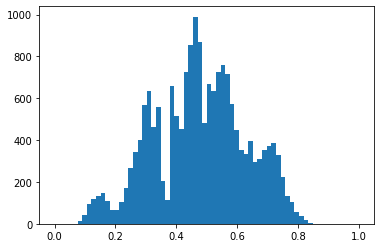

In [143]:
pred_a_1 = prediction_df[prediction_df.label==1].iloc[:,1:].values
_ = plt.hist(pred_a_1.reshape(-1,1), bins='auto', range=(0.,1.)) 
plt.show()

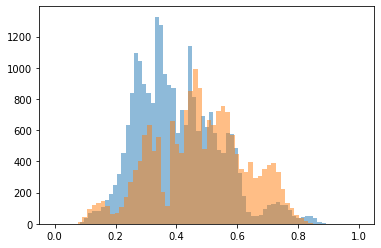

In [144]:
_ = plt.hist(pred_a_0.reshape(-1,1), bins='auto', range=(0.,1.),alpha=0.5) 
_ = plt.hist(pred_a_1.reshape(-1,1), bins='auto', range=(0.,1.),alpha=0.5) 
plt.show()

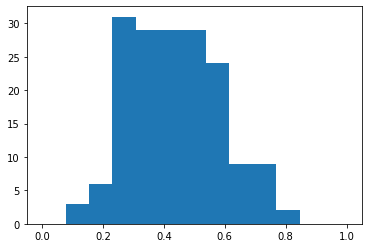

In [145]:
pred_a_med = prediction_df.median_pred
_ = plt.hist(pred_a_med, bins='auto', range=(0,1)) 
plt.show()

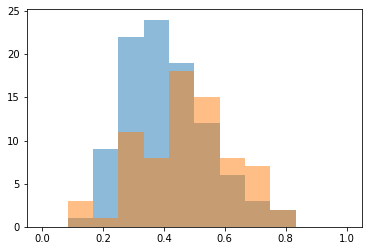

In [146]:
pred_a_med_0 = pred_a_med[prediction_df.label==0]
pred_a_med_1 = pred_a_med[prediction_df.label==1]
_ = plt.hist(pred_a_med_0, bins='auto', range=(0.,1.),alpha=0.5) 
_ = plt.hist(pred_a_med_1, bins='auto', range=(0.,1.),alpha=0.5) 
plt.show()

# Visualization

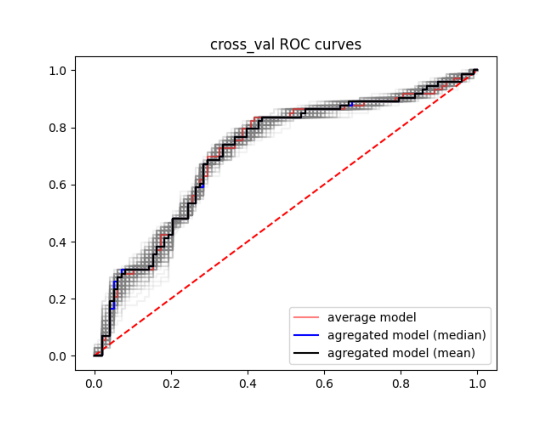

<Figure size 1382.4x1036.8 with 0 Axes>

In [243]:
# test model
results_df = full_histogram(test_model, dataset=dataset, verbose=False)

In [244]:
results_df

,true_labels
ID,
1-20FORHU_t0,0
1-23CREES_t0,0
2-02FERMA_t0,0
2-04HEBTO_t0,1
2-08BESAG_t0,0
...,...
sub-inhibition23_ses-pretraining_T1w,0
sub-inhibition24_ses-pretraining_T1w,0
sub-inhibition25_ses-pretraining_T1w,1
